In [22]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import scipy
import numpy as np
import seaborn as sns

Objetivos do Script:

Esse script tem como objetivo ler os dados que foram capturados da nossa amostra piloto e realizar alguns estudos em cima desses dados. 

Os 6 primeiros tópicos que eu separei abaixo são utilizados na grande maioria dos scripts de tratamento de dados desse estudo. 
Deixei padronizado para que seja possivel tratar simulações com um dispositivo ou vários.

Sumário:
  - Leitura dos dados
  - Separar publicações e confirmação de entrega por dispositivo simulado.
  - Criação de um dataframe com informações capturadas. 
  - Medidas de tendência centrar por dispositivo
  - Medidas de tendência centrar de todos os dispositivos.
  - Gráfico de dispersão da amostra.
  - Calculo do tamanho da amostra.

Como estamos trabalhando com uma amostra piloto temos como objetivo calcular o tamanho das amostras isso será realizado na ultima parte desse script.


In [23]:
data = pd.read_csv("./data.csv")
ports = data["Source Port"].unique()
ports = ports[ports !=1883]


In [24]:
#  - Separar publicações e confirmação de entrega por dispositivo simulado.
devices = {}
#  : devices será um dicionario que irá ter uma chave referente ao device e o valor será um dataframe referente aos respectivos devices 
for port in ports:  
  data = data.loc[ ~(data["Message Identifier"] == "1,2")]
  array_publish = data.loc[data["Source Port"] == port].dropna(subset=['Message Identifier'])
  array_publish_ack = data.loc[data["Destination Port"] == port].dropna(subset=['Message Identifier'])
  device = {"publish":array_publish, "publish_ack" : array_publish_ack}
  devices[port] = device

In [25]:
# - Criação de um dataframe com informações capturadas acima. 
data = {}
for port in ports:
    RTT = pd.DataFrame(columns=["Time_publish", "Time_ack"])
    for index, row in devices[port]["publish"].iterrows():
        id = int(row["Message Identifier"])
        time_publish = row["Time"]
        RTT.loc[id, "Time_publish"] = time_publish 

    for index, row in devices[port]["publish_ack"].iterrows():
        id = int(row["Message Identifier"])
        time_publish = row["Time"]
        RTT.loc[id, "Time_ack"] = time_publish
    RTT.loc[id, "Time_ack"] = time_publish
    RTT["RTT"]  =(RTT["Time_ack"] - RTT["Time_publish"] )* 1000
    data[port] = RTT


## Medidas de Tendência Central Por Device

In [26]:
i=1
data_mean = []
data_median = []
data_std = []
data_min = []
data_max = []

for port in ports:
  data_mean.append(data[port]["RTT"].mean())
  data_median.append(data[port]["RTT"].mean())
  data_std.append(data[port]["RTT"].mean())
  data_min.append(data[port]["RTT"].mean())
  data_max.append(data[port]["RTT"].mean())

  print("(Device-{})Mean Round Trip Time = {}".format(i ,data[port]["RTT"].mean()))
  print("(Device-{})Median Round Trip Time = {}".format(i ,data[port]["RTT"].median()))
  print("(Device-{})Standard deviation  Round Trip Time = {}".format(i ,data[port]["RTT"].std()))
  print("(Device-{})Min Round Trip Time = {}".format(i ,data[port]["RTT"].min()))
  print("(Device-{})Max Round Trip Time = {}".format(i ,data[port]["RTT"].max()))
  print("---------------------------------------------------------------")

  i+=1

(Device-1)Mean Round Trip Time = 17.150062999999882
(Device-1)Median Round Trip Time = 17.150062999999882
(Device-1)Standard deviation  Round Trip Time = nan
(Device-1)Min Round Trip Time = 17.150062999999882
(Device-1)Max Round Trip Time = 17.150062999999882
---------------------------------------------------------------
(Device-2)Mean Round Trip Time = 31.835619035172734
(Device-2)Median Round Trip Time = 31.929171999991013
(Device-2)Standard deviation  Round Trip Time = 1.2137428456665438
(Device-2)Min Round Trip Time = 29.744401000016296
(Device-2)Max Round Trip Time = 36.49570799996127
---------------------------------------------------------------


## Medidas de Tendência Central Geral

In [27]:
from statistics import mean 

print("Mean Round Trip Time = {}".format(mean(data_mean)))
print("Median Round Trip Time = {}".format(mean(data_median)))
print("Standard deviation  Round Trip Time = {}".format(mean(data_std)))
print("Min Round Trip Time = {}".format(mean(data_min)))
print("Max Round Trip Time = {}".format(mean(data_max)))


Mean Round Trip Time = 24.492841017586308
Median Round Trip Time = 24.492841017586308
Standard deviation  Round Trip Time = 24.492841017586308
Min Round Trip Time = 24.492841017586308
Max Round Trip Time = 24.492841017586308


## Gráfico de Dispersão

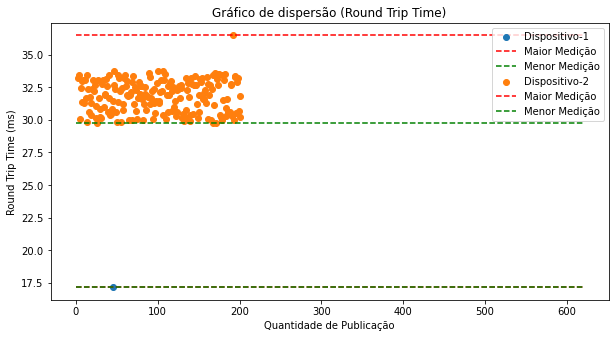

In [28]:
import matplotlib 
i=1
fig, ax = plt.subplots(figsize=(10,5),dpi=72)
for port in ports:
  ax.scatter(data[port]["RTT"].index,data[port]["RTT"], label='Dispositivo-{}'.format(i))
  ax.set_ylabel('Round Trip Time (ms)')
  ax.set_xlabel('Quantidade de Publicação')
  ax.set_title('Gráfico de dispersão (Round Trip Time)')
  ax.hlines(data[port]["RTT"].max(),  xmin=0, xmax=620, colors="red", linestyles="dashed", label="Maior Medição")
  ax.hlines(data[port]["RTT"].min(),  xmin=0, xmax=620, colors="green", linestyles="dashed", label="Menor Medição")
  ax.legend()
  i+=1


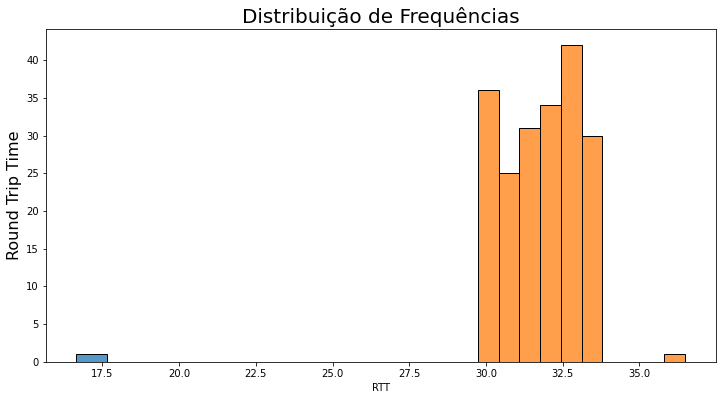

In [29]:
i=1
fig, ax = plt.subplots(figsize=(20,5),dpi=72)
for port in ports:
  ax = sns.histplot(data[port]["RTT"])
  ax.figure.set_size_inches(12, 6)
  ax.set_title('Distribuição de Frequências', fontsize=20)
  ax.set_ylabel('Round Trip Time', fontsize=16)
  ax.grid()
  i+=1

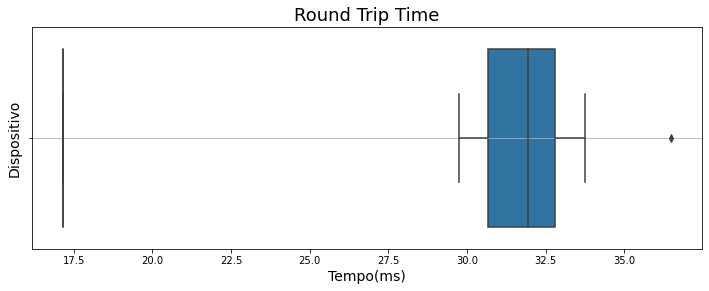

In [30]:
fig, ax = plt.subplots(figsize=(20,5),dpi=72)
for port in ports:
  ax = sns.boxplot(x = 'RTT', data = data[port], orient = 'h')
  ax.figure.set_size_inches(12, 4)
  ax.set_title('Round Trip Time', fontsize=18)
  ax.set_xlabel('Tempo(ms)', fontsize=14)
  ax.set_ylabel('Dispositivo', fontsize=14)
  ax.grid()



In [31]:
## Analisando outliers
df_novo = {}
for port in ports:
  data[port]
  q3, q1 = np.percentile(data[port]["RTT"], [75, 25])
  interquartil = q3 - q1
  limite_superior =q3 + 1.5 * interquartil
  limite_inferior = q1 - 1.5 * interquartil 
  df_novo[port] = data[port].loc[((data[port]["RTT"]>limite_inferior) & (data[port]["RTT"]<limite_superior))]
  dados_excluidos = data[port]["RTT"].shape[0] - len(df_novo[port])

  print("Q3", q3)
  print("Q1", q1)
  print("FIQ", interquartil)
  print("limite_superior", limite_superior)
  print("limite_inferior", limite_inferior)
  print("média nova", df_novo[port]["RTT"].mean())
  print("Média antiga", data[port]["RTT"].mean())
  print("Median", data[port]["RTT"].median())
  print("Median", df_novo[port]["RTT"].median())


Q3 17.150062999999882
Q1 17.150062999999882
FIQ 0.0
limite_superior 17.150062999999882
limite_inferior 17.150062999999882
média nova nan
Média antiga 17.150062999999882
Median 17.150062999999882
Median nan
Q3 32.84444899998107
Q1 30.685870000013438
FIQ 2.158578999967631
limite_superior 36.082317499932515
limite_inferior 27.44800150006199
média nova 31.812083232320266
Média antiga 31.835619035172734
Median 31.929171999991013
Median 31.921566499988785


/home/joaog/Desensolvimento/pessoal/tcc/analise-mqtt-iot/iot-analise-tcc/Data_analytics/calc/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


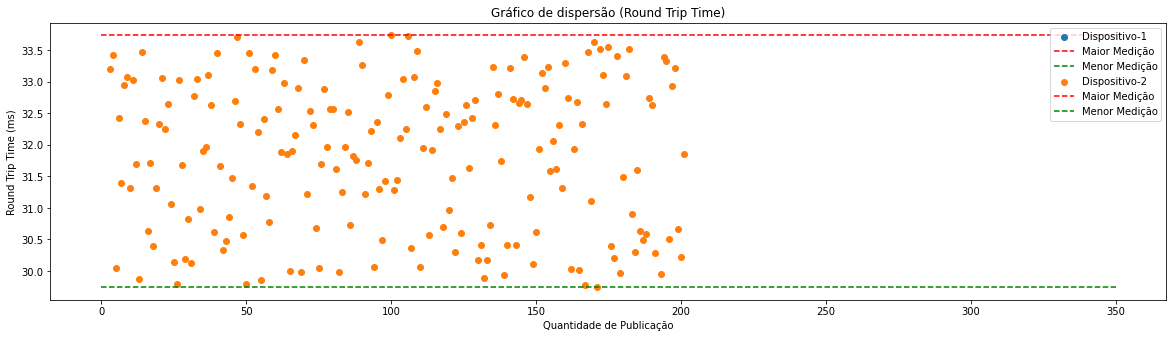

In [32]:
import matplotlib 

i=1
fig, ax = plt.subplots(figsize=(20,5),dpi=72)
for port in ports:
  ax.scatter(df_novo[port]["RTT"].index,df_novo[port]["RTT"], label='Dispositivo-{}'.format(i))
  ax.set_ylabel('Round Trip Time (ms)')
  ax.set_xlabel('Quantidade de Publicação')
  ax.set_title('Gráfico de dispersão (Round Trip Time)')
  ax.hlines(df_novo[port]["RTT"].max(),  xmin=0, xmax=350, colors="red", linestyles="dashed", label="Maior Medição")
  ax.hlines(df_novo[port]["RTT"].min(),  xmin=0, xmax=350, colors="green", linestyles="dashed", label="Menor Medição")
  ax.legend()
  i+=1


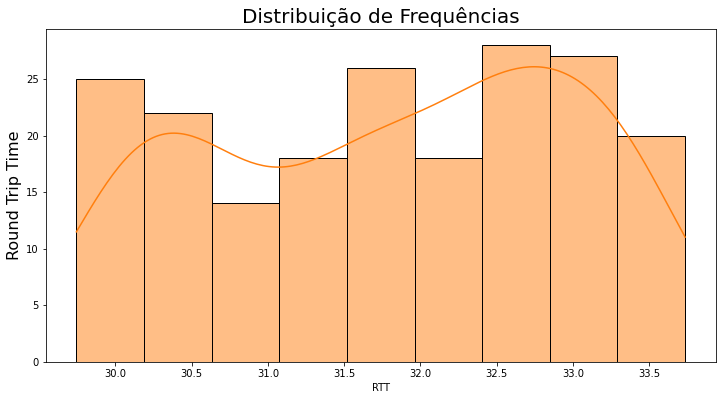

In [33]:
i=1
fig, ax = plt.subplots(figsize=(20,5),dpi=72)
for port in ports:
  ax = sns.histplot(df_novo[port]["RTT"], kde=True)
  ax.figure.set_size_inches(12, 6)
  ax.set_title('Distribuição de Frequências', fontsize=20)
  ax.set_ylabel('Round Trip Time', fontsize=16)
  ax.grid()
  i+=1

# CÁLCULO DO TAMANHO DA AMOSTRA

In [34]:
nivel_de_significancia = 0.05

In [35]:
nivel_de_confiança = 1 - nivel_de_significancia
nivel_de_confiança

0.95

In [36]:
#Calculando o z com scipy
z = scipy.stats.norm.ppf(0.975)
z

1.959963984540054

Com nosso z calculado podemos seguir adiante

### $$z = 1.959963984540054 $$

Abaixo segue algumas formulas que iremos utilizar para calcular o numero de amostra



## $$n = \left(z\frac{s}{e}\right)^2$$


$$e = \left(e *  \right)^2$$



Onde:

$z$ = variável normal padronizada

$s$ = desvio padrão amostral

$e$ = erro inferencial


### Calculando a desvio padrão $s$

In [37]:
desvio_padrao_amostral = RTT["RTT"].std()
desvio_padrao_amostral

1.2137428456665438

### Calculando o Erro

In [38]:
media = RTT["RTT"].mean()
e = 0.05 * media
e

1.5917809517586368

### Calculando o tamanho da nossa amostra

In [39]:
n = (z * (desvio_padrao_amostral/e))**2
n

2.2334844919542562

In [40]:
n = (z * (desvio_padrao_amostral/e))**2

In [41]:
n

2.2334844919542562